# dev-pictulize-basics

### references

* [using nst in tf hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb#scrollTo=lnAv-F3O9fLV)
* [load images in tf](https://www.tensorflow.org/tutorials/load_data/images)
* [download tf hub module](https://stackoverflow.com/questions/50322001/how-to-save-load-a-tensorflow-hub-module-to-from-a-custom-path)

## environment setup

In [3]:
import functools
import os

import numpy as np
import matplotlib
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from pathlib import Path
from PIL import Image
import urllib.request
import tarfile

print(f'matplotlib version: {matplotlib.__version__}')
print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

matplotlib version: 3.1.3
TF Version:  2.1.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
GPU available:  False


In [24]:
## utility functions
def untar(fpath):
    fpath= Path(fpath)
    if str(fpath).endswith("tar.gz"):
        tar = tarfile.open(fpath, "r:gz")
        tar.extractall(fpath.parent)
        tar.close()
    elif str(fpath).endswith("tar"):
        tar = tarfile.open(fpath, "r:")
        tar.extractall(fpath.parent)
        tar.close()
        
def decode_img(img_path):
    img = tf.io.read_file(str(img_path))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [400,400])
    return img

def viz_img(tensor):
    if len(tensor.shape) > 3:
        tensor = tf.squeeze(tensor,0)
    return Image.fromarray(np.uint8(np.array(tensor)*255.))

In [23]:
## paths
path_model_folder = Path('../model')
path_model_compressed = Path('../model/magenta_arbitrary-image-stylization-v1-256_2.tar.gz')
if not path_model_folder.exists():
    path_model_folder.mkdir()
    
content_image_path = Path('./images/content/brad_pitt.jpg')
#style_image_path = Path('./images/style/mosaic.jpg')
style_image_path = Path('./images/style/colors_abstract.jpg')
output_image_path = Path('./images/style/output.jpg')

## code

### download model

In [6]:
# Download Hub Module and load it
nst_model_download_link = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2?tf-hub-format=compressed'
urllib.request.urlretrieve(nst_model_download_link, path_model_compressed) ## download
untar(path_model_compressed) ## decompress

### load model

In [9]:
hub_module = hub.load(str(path_model_folder))

### apply model

In [25]:
img_cnt = decode_img(str(content_image_path))
img_cnt = tf.expand_dims(img_cnt, 0) if len(img_cnt.shape) == 3 else img_cnt
img_style = decode_img(str(style_image_path))
img_style = tf.expand_dims(img_style, 0) if len(img_style.shape) == 3 else img_style

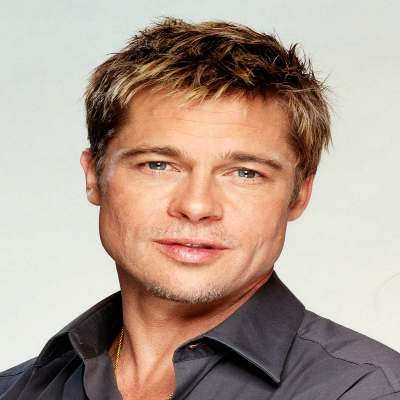

In [26]:
viz_img(img_cnt)

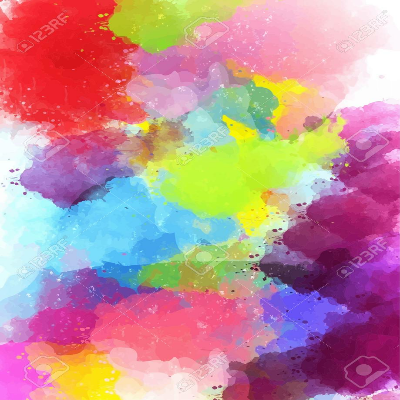

In [27]:
viz_img(img_style)

## run algo

In [39]:
outputs = hub_module(tf.constant(img_cnt), tf.constant(img_style))
img_output = outputs[0]

### visualize the result

In [44]:
## show images
def show_n(images, titles=('',)):
    """
    from: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb#scrollTo=nnGvWQAezmxp
    """
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w  * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

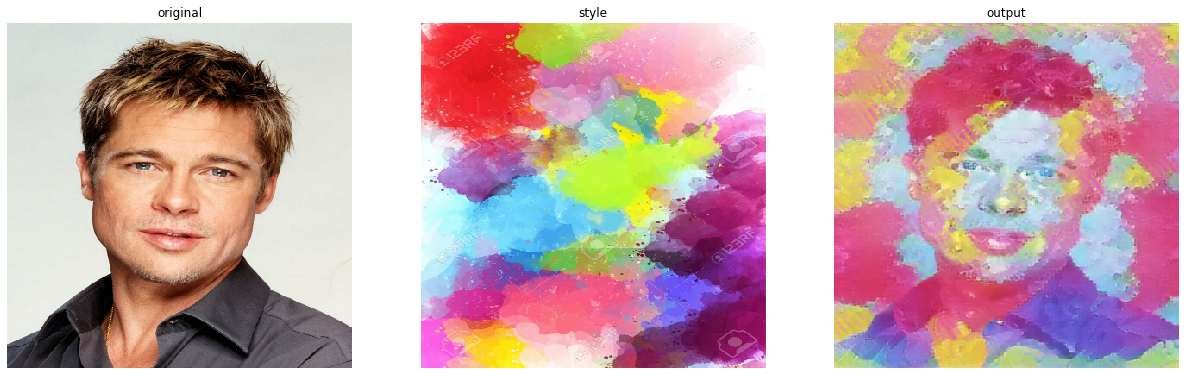

In [45]:
show_n([img_cnt, img_style, img_output], titles=['original', 'style', 'output'])